In [1]:
# importa e instala o SimPEG
# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_fwd_1_dcr_sounding.html#sphx-glr-content-tutorials-05-dcr-plot-fwd-1-dcr-sounding-py

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt   # precisava desta linha
!python setup.py install

fatal: destination path 'simpeg' already exists and is not an empty directory.
/content/simpeg
Obtaining file:///content/simpeg (from -r requirements.txt (line 1))
  Found existing installation: SimPEG 0.14.3
    Uninstalling SimPEG-0.14.3:
      Successfully uninstalled SimPEG-0.14.3
  Running setup.py develop for SimPEG
running install
running bdist_egg
running egg_info
writing SimPEG.egg-info/PKG-INFO
writing dependency_links to SimPEG.egg-info/dependency_links.txt
writing requirements to SimPEG.egg-info/requires.txt
writing top-level names to SimPEG.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'SimPEG.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/SimPEG
copying build/lib/SimPEG/inversion.py -> build/bdist.linux-x86_64/egg/SimPEG
copying build/lib/SimPEG/directives.py -> build/bdist.linux-x86_64/egg/S

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import plot_layer

save_file = False

In [3]:
# configuração da SEV Schlumberger

import numpy as np

schlumberger = np.array([[1.5, 0.5],
                        [2.0, 0.5],
                        [3.0, 0.5],
                        [4.0, 0.5],
                        [5.0, 0.5],
                        [6.0, 0.5],
                        [8.0, 1.0],
                        [10.0, 1.0],
                        [12.0, 1.0],
                        [15.0, 2.0],
                        [20.0, 2.0],
                        [25.0, 2.0],
                        [30.0, 2.0],
                        [40.0, 5.0],
                        [50.0, 5.0],
                        [60.0, 10.0],
                        [80.0, 10.0],
                        [100.0, 10.0],
                        [150.0, 10.0],
                        [200.0, 10.0]])

source_list_schlumberger = []

for ii in range(schlumberger.shape[0]):
  A = np.r_[-1 * schlumberger[ii, 0], 0.0,0.0]
  B = np.r_[schlumberger[ii, 0], 0.0,0.0]
  M = np.r_[-1 * schlumberger[ii, 1], 0.0,0.0]
  N = np.r_[ schlumberger[ii, 1], 0.0,0.0]

  receiver_list = [dc.receivers.Dipole(M, N)]
  source_list_schlumberger.append(dc.sources.Dipole(receiver_list, A, B))

survey_schlumberger = dc.Survey(source_list_schlumberger)

In [4]:
# arranjo wenner
aberturas = np.array([1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0, \
                      25.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0, 150.0, 200.0])      # posições dos eletrodos A

wenner = np.array([[a, a/3] for a in aberturas])

source_list_wenner = []

for ii in range(wenner.shape[0]):
  A = np.r_[-1 * wenner[ii, 0], 0.0,0.0]
  B = np.r_[wenner[ii, 0], 0.0,0.0]
  M = np.r_[-1 * wenner[ii, 1], 0.0,0.0]
  N = np.r_[ wenner[ii, 1], 0.0,0.0]

  receiver_list = [dc.receivers.Dipole(M, N)]
  source_list_wenner.append(dc.sources.Dipole(receiver_list, A, B))

survey_wenner = dc.Survey(source_list_wenner)

In [5]:
# modelo 1D - S40 Bebedouro
model = np.r_[50.0, 300.0, 35.0, 1000]
layer_thicknesses = np.r_[0.5, 5.0, 80.0]
model_map = maps.IdentityMap(nP=len(model))

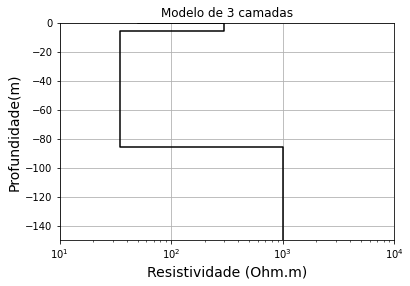

In [6]:
max_depth = 150
mesh = TensorMesh([np.r_[layer_thicknesses, max_depth - layer_thicknesses.sum()]])
plot_layer(model_map * model, mesh)

plt.xlabel('Resistividade (Ohm.m)')
plt.ylabel('Profundidade(m)')
plt.title('Modelo de 3 camadas')
plt.xlim([10, 1e4])
plt.grid()
plt.show()

In [7]:
# Modelagens
simulation_schlumberger = dc.simulation_1d.Simulation1DLayers(
    survey = survey_schlumberger,
    rhoMap = model_map,
    thicknesses=layer_thicknesses,
    data_type="apparent_resistivity"
)

dpred_schlumberger = simulation_schlumberger.dpred(model)


simulation_wenner = dc.simulation_1d.Simulation1DLayers(
    survey = survey_schlumberger,
    rhoMap = model_map,
    thicknesses=layer_thicknesses,
    data_type="apparent_resistivity"
)

dpred_wenner = simulation_wenner.dpred(model)

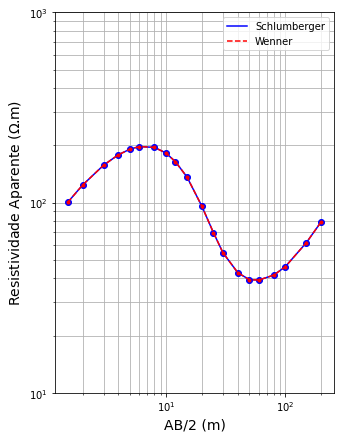

In [10]:
fig, ax1 = plt.subplots(figsize=(5, 7))
ax1.loglog(schlumberger[:,0], dpred_schlumberger, 'b', label='Schlumberger')
ax1.plot(schlumberger[:,0], dpred_schlumberger, 'ob')
ax1.loglog(wenner[:,0], dpred_wenner, '--r', label='Wenner')
ax1.plot(wenner[:,0], dpred_wenner, '.r')
ax1.set_xlabel('AB/2 (m)', fontsize='14')
ax1.set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
ax1.set_ylim([10, 1000])
ax1.legend(loc='upper right')
ax1.grid(which='both')
plt.show()